# Evaluating Predictions

[*Andrew Wheeler*, PhD](mailto:andrew.wheeler@hms.com)

This is an example notebook to go along with the Evaluating Predictions presentation.

In [1]:
#Loading in the libraries we will be using
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

#The models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#For evaluation
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

#Setting the working directory to where our data is stored
os.chdir(r'C:\Users\e009156\Documents\GitHub\data-science-utils\education\Intro_DataScience\Evaluating_Predictions\Analysis')

#Reading in the CSV data of food inspections
insp_dat = pd.read_csv('FoodInspect.csv')

#A quick view of the first few rows of data
insp_dat.head()

,Inspection_ID,Inspector,pastSerious,pastCritical,timeSinceLast,ageAtInspection,consumption_on_premises_incidental_activity,tobacco_retail_over_counter,temperatureMax,heat_sanitation,heat_garbage,criticalFound
0,269961,green,0,0,2.0,1,0,1,53.496667,37.748787,12.768572,0
1,507211,blue,0,0,2.0,1,0,0,59.046667,15.412267,12.895485,0
2,507212,blue,0,0,2.0,1,0,0,59.046667,8.320330,8.004220,0
3,507216,blue,0,0,2.0,1,0,0,56.153333,38.186618,26.238645,0
4,507219,blue,0,0,2.0,1,0,0,52.730000,2.126788,3.401567,0


In [2]:
#Data Prep

#We only have a few inspectors, so dummy coding those
print( insp_dat['Inspector'].value_counts() )
insp_dum = pd.get_dummies(insp_dat['Inspector'], drop_first=False)
my_dat = pd.concat([insp_dat, insp_dum], axis=1)

#variable we are predicting -- if restaurant failed their inspection
dep_var = 'criticalFound'

#Inspection ID is not needed for the predictive model
drop_vars = ['Inspection_ID','Inspector']  #I dont want these variables in the model
ind_vars =  list( set(my_dat) - set(drop_vars + [dep_var]) )
print("\nIndependent Variables")
print(ind_vars)

green     4940
orange    4068
blue      3434
yellow    3004
brown     1993
purple    1273
Name: Inspector, dtype: int64

Independent Variables
['tobacco_retail_over_counter', 'yellow', 'pastSerious', 'blue', 'orange', 'heat_sanitation', 'brown', 'ageAtInspection', 'temperatureMax', 'timeSinceLast', 'consumption_on_premises_incidental_activity', 'purple', 'green', 'pastCritical', 'heat_garbage']


In [3]:
#Now creating a train dataset (70% of the data, ~13,000 cases) and a test dataset (30% of the data, ~5,000 cases)
train, test = train_test_split(my_dat, test_size=0.3)

#Estimating the models on the TRAINING data

#estimating a logistic regression model
logit_model = LogisticRegression(penalty='none', solver='newton-cg',fit_intercept=False) 
logit_model.fit(X = train[ind_vars], y = train[dep_var])

#estimating a random forest model
rf_model = RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_leaf=30)
rf_model.fit(X = train[ind_vars], y = train[dep_var])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [4]:
#Generating Predicted Probabilities on the TEST dataset for each model
pred_probL = logit_model.predict_proba(X = test[ind_vars])[::,1]
pred_probR = rf_model.predict_proba(X = test[ind_vars])[::,1]

#Generating a confusion matrix, setting threshold to predict failed inspection at 30%
th = 0.30
con_matL = pd.DataFrame(confusion_matrix(test[dep_var], pred_probL > th),
                       columns=['Predict Pass','Predict Fail'], index=['Pass Inspect', 'Fail Inspect'])
con_matR = pd.DataFrame(confusion_matrix(test[dep_var], pred_probR > th),
                       columns=['Predict Pass','Predict Fail'], index=['Pass Inspect', 'Fail Inspect'])

#The correct guesses are on the diagonal of the confusion matrix
accuracyL = (con_matL.iloc[0,0] + con_matL.iloc[1,1] ) / len(test)
print("Accuracy Logit Model")
print("%.2f" % accuracyL)
print( con_matL )

accuracyR = (con_matR.iloc[0,0] + con_matR.iloc[1,1] ) / len(test)
print("\nAccuracy Random Forest Model")
print("%.2f" % accuracyR)
print( con_matR )

Accuracy Logit Model
0.83
              Predict Pass  Predict Fail
Pass Inspect          4459           349
Fail Inspect           615           191

Accuracy Random Forest Model
0.83
              Predict Pass  Predict Fail
Pass Inspect          4494           314
Fail Inspect           641           165


In [5]:
#Evaluating the AUC of the two models, and plot the ROC curves

#Getting the ROC curve statistics
fprL, tprL, threshL = roc_curve(test[dep_var], pred_probL, pos_label=1)
fprR, tprR, threshR = roc_curve(test[dep_var], pred_probR, pos_label=1)

#Calculating the Area Under the Curve for each model
aucL = auc(fprL, tprL)
print("AUC Statistic for Logit Model")
print(round(aucL,2))

aucR = auc(fprR, tprR)
print("\nAUC Statistic for Random Forest Model")
print(round(aucR,2))

AUC Statistic for Logit Model
0.71

AUC Statistic for Random Forest Model
0.71


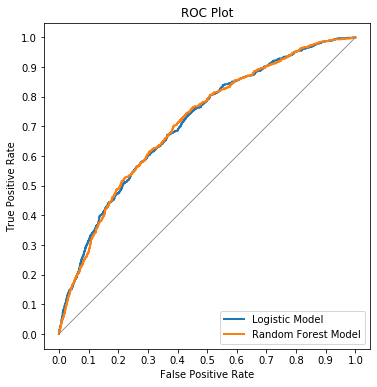

In [6]:
#Now making an ROC graph to illustrate
fig, ax = plt.subplots()
fig.set_size_inches(6,6)
ax.plot(fprL, tprL, drawstyle='steps-post', label='Logistic Model', linewidth=2)
ax.plot(fprR, tprR, drawstyle='steps-post', label='Random Forest Model', linewidth=2)
ax.plot([0,1], [0,1], color='grey', linewidth=0.8) #mid-reference line
ax.set_title("ROC Plot") 
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
ax.legend(loc='lower right')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_aspect(aspect='equal')
plt.show()